In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv")
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


##### Data processing to convert date column to standard format

In [10]:
# Convert 'Date' column to datetime with the correct format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

print(df)

           Date  Price
0    1987-05-20  18.63
1    1987-05-21  18.45
2    1987-05-22  18.55
3    1987-05-25  18.60
4    1987-05-26  18.63
...         ...    ...
9006 2022-11-08  96.85
9007 2022-11-09  93.05
9008 2022-11-10  94.25
9009 2022-11-11  96.37
9010 2022-11-14  93.59

[9011 rows x 2 columns]


##### Visualizing the data using a line plot

Text(0.5, 1.0, 'Brent Oil Price Trend')

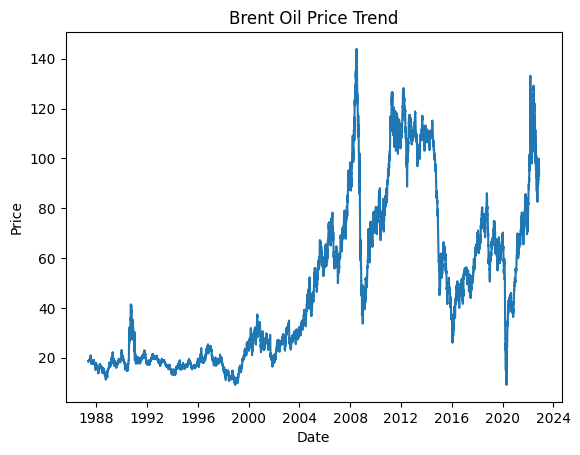

In [11]:
g = sns.lineplot(x='Date',y='Price',data = df)
plt.title("Brent Oil Price Trend")

##### merging the different data

In [12]:
import pandas as pd

# Load Brent oil prices
brent_prices = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv', parse_dates=['Date'])

# Load the historical events data
events_data = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/oil_related_events.csv')

# Ensure the event year is in datetime format for merging
events_data['Year'] = pd.to_datetime(events_data['Year'], format='%Y')

# Merge datasets based on year
merged_data = pd.merge_asof(
    brent_prices.sort_values('Date'), 
    events_data.sort_values('Year'), 
    left_on='Date', 
    right_on='Year', 
    direction='backward'  # Align the closest previous event
)

# Save to CSV
merged_data.to_csv('merged_brent_oil_price_and_related_events.csv', index=False)
# Display the merged dataset
print(merged_data.head())


C:\Users\elbet\AppData\Local\Temp\ipykernel_157668\1357778169.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_prices = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/data/BrentOilPrices.csv', parse_dates=['Date'])


        Date  Price Year Event
0 1987-05-20  18.63  NaT   NaN
1 1987-05-21  18.45  NaT   NaN
2 1987-05-22  18.55  NaT   NaN
3 1987-05-25  18.60  NaT   NaN
4 1987-05-26  18.63  NaT   NaN
